In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '06'

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [3]:
idx_explain = 0

In [4]:
feature1 = []
feature2 = []
for x in X:
    feature1.append(x[0])
    feature2.append(x[1])

feature1 = np.asarray(feature1)
feature2 = np.asarray(feature2)

y = y.astype(str)

d = {'y': y, 'feature_1': feature1, 'feature_2': feature2}

df = pd.DataFrame(d)

dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [5]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [6]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([2940,  319]))


Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


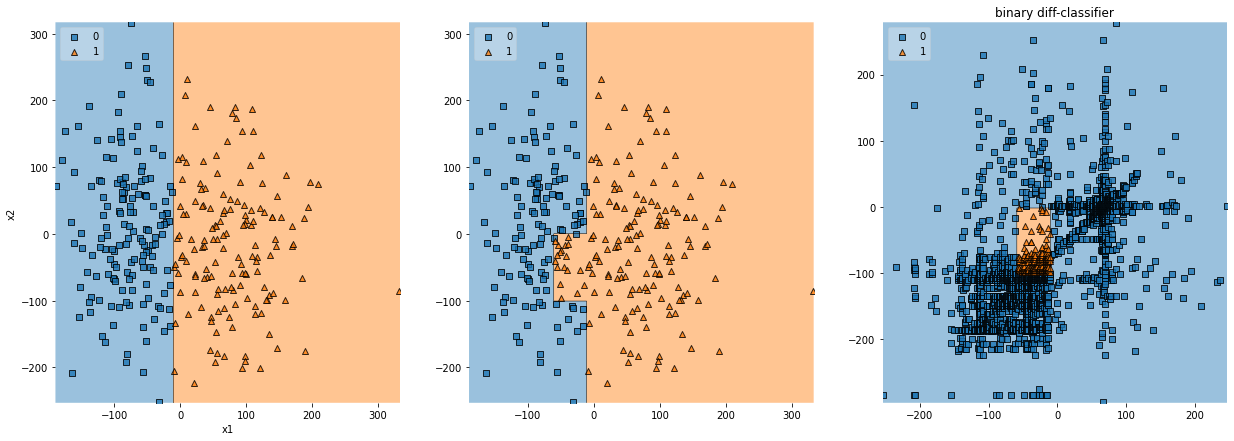

In [7]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.integer), clf=dc_full, ax=ax[2], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('binary diff-classifier')

plt.show()

[Text(372.0, 830.5, 'x2 <= -99.5\ngini = 0.177\nsamples = 3259\nvalue = [2940, 319]\nclass = no_diff'),
 Text(279.0, 679.5, 'gini = 0.0\nsamples = 1593\nvalue = [1593, 0]\nclass = no_diff'),
 Text(465.0, 679.5, 'x2 <= -69.5\ngini = 0.31\nsamples = 1666\nvalue = [1347, 319]\nclass = no_diff'),
 Text(186.0, 528.5, 'x1 <= -59.0\ngini = 0.436\nsamples = 432\nvalue = [139, 293]\nclass = diff'),
 Text(93.0, 377.5, 'gini = 0.0\nsamples = 111\nvalue = [111, 0]\nclass = no_diff'),
 Text(279.0, 377.5, 'x1 <= -10.0\ngini = 0.159\nsamples = 321\nvalue = [28, 293]\nclass = diff'),
 Text(186.0, 226.5, 'gini = 0.0\nsamples = 293\nvalue = [0, 293]\nclass = diff'),
 Text(372.0, 226.5, 'gini = 0.0\nsamples = 28\nvalue = [28, 0]\nclass = no_diff'),
 Text(744.0, 528.5, 'x1 <= -10.0\ngini = 0.041\nsamples = 1234\nvalue = [1208, 26]\nclass = no_diff'),
 Text(651.0, 377.5, 'x2 <= -1.5\ngini = 0.304\nsamples = 139\nvalue = [113, 26]\nclass = no_diff'),
 Text(558.0, 226.5, 'x1 <= -58.5\ngini = 0.488\nsamples =

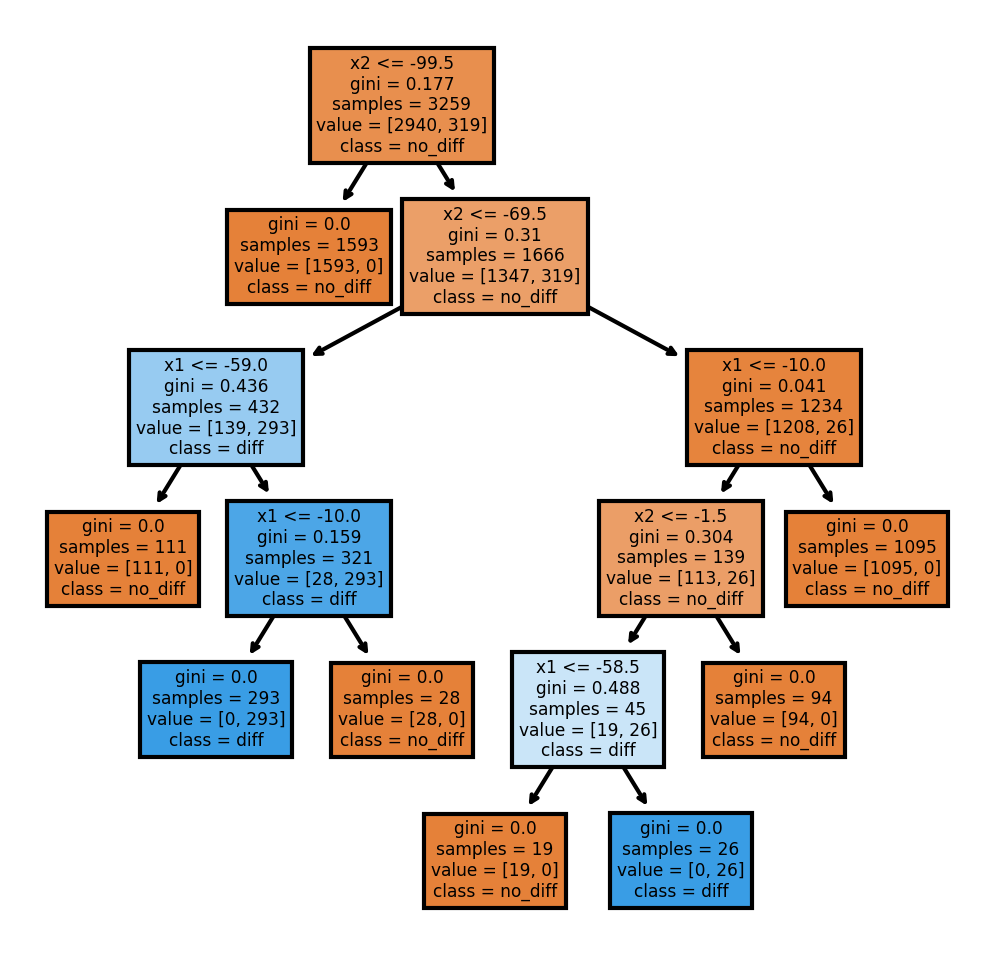

In [8]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [9]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{feature_2 > -99.5, feature_2 <= -69.5, feature_1 > -59.0, feature_1 <= -10.0}'}
{'diff': '{feature_2 > -99.5, feature_2 > -69.5, feature_1 <= -10.0, feature_2 <= -1.5, feature_1 > -58.5}'}


## Multiclass difference explanations

In [10]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [11]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [12]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 4]), array([1805,  936,  427]))


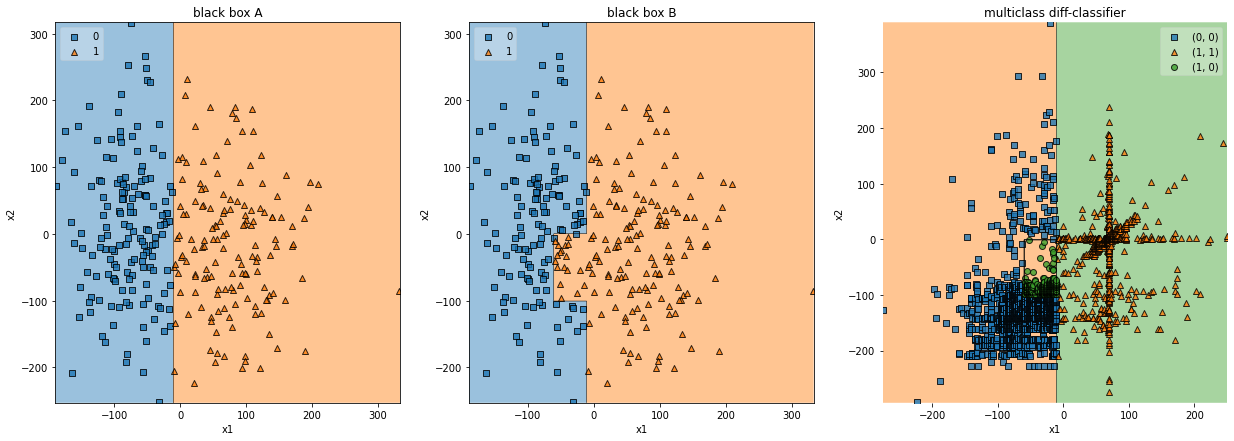

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, hide_spines=False)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, hide_spines=False)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.int64), clf=dc_full, ax=ax[2], legend=2)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[1])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(465.0, 815.4, 'x1 <= -10.5\ngini = 0.57\nsamples = 3168\nvalue = [1805, 936, 427]\nclass = (0, 0)'),
 Text(310.0, 634.2, 'x2 <= -99.5\ngini = 0.309\nsamples = 2232\nvalue = [1805, 0, 427]\nclass = (0, 0)'),
 Text(155.0, 453.0, 'gini = 0.0\nsamples = 1594\nvalue = [1594, 0, 0]\nclass = (0, 0)'),
 Text(465.0, 453.0, 'x1 <= -60.0\ngini = 0.443\nsamples = 638\nvalue = [211, 0, 427]\nclass = (1, 0)'),
 Text(310.0, 271.80000000000007, 'gini = 0.0\nsamples = 150\nvalue = [150, 0, 0]\nclass = (0, 0)'),
 Text(620.0, 271.80000000000007, 'x2 <= -0.5\ngini = 0.219\nsamples = 488\nvalue = [61, 0, 427]\nclass = (1, 0)'),
 Text(465.0, 90.60000000000002, 'gini = 0.0\nsamples = 427\nvalue = [0, 0, 427]\nclass = (1, 0)'),
 Text(775.0, 90.60000000000002, 'gini = 0.0\nsamples = 61\nvalue = [61, 0, 0]\nclass = (0, 0)'),
 Text(620.0, 634.2, 'gini = 0.0\nsamples = 936\nvalue = [0, 936, 0]\nclass = (1, 1)')]

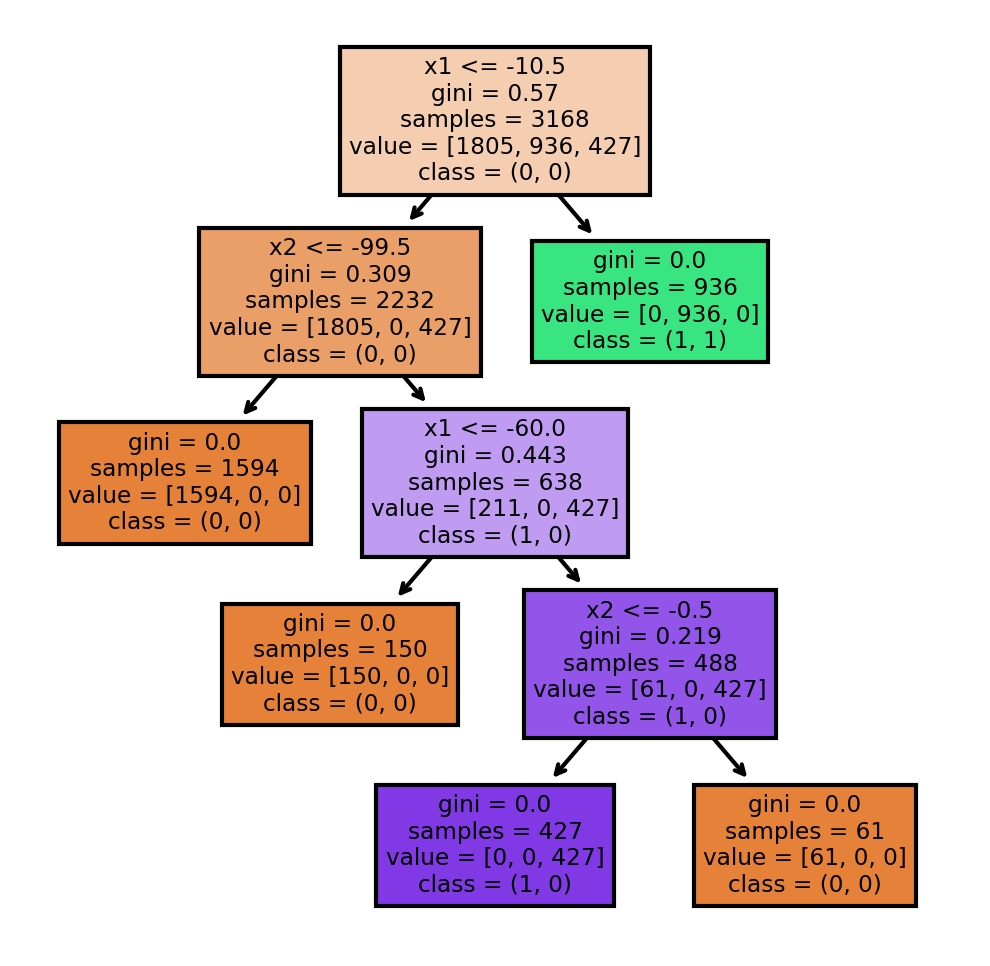

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)